In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import warnings
warnings.simplefilter("ignore")
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering

In [4]:
population = {'Paris': 9803494, 'Helsinki': 1106418, 'Edinburgh': 495710, 'London': 8606201, 'Bratislava': 425923, 'Lisbon': 1859838,
       'Budapest': 1749734, 'Stockholm': 1716807, 'Rome': 1362103, 'Milan': 1967861, 'Munich':708422, 'Hamburg': 1830584,
       'Prague': 652780, 'Vienna': 916150, 'Dublin': 1305300, 'Barcelona': 3665687, 'Brussels': 614177, 'Madrid': 3165541,
       'Oslo': 613285, 'Amsterdam': 810938, 'Berlin': 3613495, 'Lyon':1074695, 'Athens': 1256209, 'Warsaw': 939250,
       'Oporto': 508349, 'Krakow': 761873, 'Copenhagen': 559440, 'Luxembourg': 111287, 'Zurich': 314250, 'Geneva':189116,
       'Ljubljana': 288919}

In [5]:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava', 'Vienna', 'Rome', 'Madrid',
       'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh', 'Ljubljana', 'Athens',
       'Luxembourg']

In [6]:
negative = ['poor', 'terrible', 'disappoint', 'horrible', 'overpriced', 'strange', 'refused', 'unappealing', 'worst', 'boring', 'racism',
         'bad', 'expensive','careful', 'appalling', ':(', 'amateur', 'dirty', 'rude', 'wretched', 'mean', 'amiss']

In [7]:
positive = ['unique', 'great', 'good', 'heavenly', 'brilliant', 'amazing', 'tasty', 'delicious', 'healthy', 'perfect', 'nice', 
       'wonderful', 'delight', 'enjoy', 'awesome', 'super', 'charm', 'excellent', 'lovely', ':)', 'friendly', 'yum', 'beautiful',
       'fresh', 'fantastic', 'talent', 'grand', 'relax', 'best', 'modern', 'cosy', 'right']

In [8]:
data = pd.read_csv('kaggle_task.csv')
Restaurant_id = np.array(data['Restaurant_id'])

In [9]:
def feature_engineer(dataset):


    #Reading original dataset
    df = pd.read_csv(dataset)

    #First/Last Review Date Features
    #extracting date from review columns
    df['First Review'] = df['Reviews'].str.extract(r'(\d{2}\/\d{2}\/\d{4}(?=\'\]))')
    df['Last Review'] = df['Reviews'].str.extract(r'(\d{2}\/\d{2}\/\d{4}(?!\'\]))')

    #converting to datetime
    df['First Review'] = pd.to_datetime(df['First Review'], format = "%m/%d/%Y")
    df['Last Review'] = pd.to_datetime(df['Last Review'], format = "%m/%d/%Y")
    df['First Review'] = df['First Review'].fillna(999)
    df['Last Review'] = df['Last Review'].fillna(999)
    
    #converting to UNIX time for model properly working
    df['Last Review'] = df['Last Review'].apply(lambda x: time.mktime(x.timetuple())/24/60/60 if x!=999 else x).astype(float)
    df['First Review'] = df['First Review'].apply(lambda x: time.mktime(x.timetuple())/24/60/60 if x!=999 else x).astype(float)
    #filling missed values
    mean_first_rev = df['First Review'].mean()
    df['First Review'] = df['First Review'].apply(lambda x: mean_first_rev if x==999 else x)
    mean_last_rev = df['Last Review'].mean()
    df['Last Review'] = df['Last Review'].apply(lambda x: mean_last_rev if x==999 else x)

    #calculating time difference between first and last review, last review and today
    df['First to Last Review'] = df['Last Review'] - df['First Review']
    df['First to Last Review'] = df['First to Last Review'].apply(lambda x: -x if x<0 else x).astype(int)
    df['Last Review to Today'] = (time.mktime(datetime.today().timetuple())/24/60/60 - df['Last Review']).astype(int)

    #Is the restaurant located in the capital?
    df['Capital'] = df['City'] 
    df['Capital'] = df['Capital'].apply(lambda x: 1 if x in capitals else 0)
    
    #city's population
    #df['Population'] = df['City'].apply(lambda x: population[x])

    #Is a given review positive?
    df['Reviews'] = df['Reviews'].astype(str)
    df['Reviews'] = df['Reviews'].str.split(pat = "],", expand=True)[0]
    df['Reviews'] = df['Reviews'].str.replace("'","")
    df['Reviews'] = df['Reviews'].str.replace(r'(\[\[)','')
    df['Reviews'] = df['Reviews'].str.replace(',','')
    df['Positive Feedback'] = df['Reviews'].apply(lambda x: 1 if any(word in x.lower() for word in positive) else 0)
    df['Negative Feedback'] = df['Reviews'].apply(lambda x: 1 if any(word in x.lower() for word in negative) else 0)
    #df['Neutral Feedback'] = df['Negative Feedback']+df['Positive Feedback']
    #df['Neutral Feedback'] = df['Neutral Feedback'].apply(lambda x: 1 if x==0 else 0)
    
    #Number of Cusine Styles in the restaurant
    df['Cuisine Style'] = df['Cuisine Style'].astype(str)
    df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x[1:-1] if x != "nan" else x)
    df['Number of Cusine Styles'] = df['Cuisine Style'].str.count(",") + 1
    #It the cusine style in the restaurant popular?
    popular_cusine = df['Cuisine Style'].str.split(pat = ",", expand=True).stack().value_counts().index[0:20]
    df['Popular Cusine'] = df['Cuisine Style'].apply(lambda x: 1 if any(word in x for word in popular_cusine) and x!= 'nan' else 0)

    #Decoding Price Range categorical feature
    df['Price Range'] = df['Price Range'].str.replace(r'((?<!\$)\$(?!\$))',"1")
    df['Price Range'] = df['Price Range'].str.replace(r'(\${2} - \${3})',"2")
    df['Price Range'] = df['Price Range'].str.replace(r'(\${4})',"3")
    #because $$-$$$ is the most popular price range let's change missed values on '2'
    df['Price Range'] = df['Price Range'].fillna(2) 

    #Filling missed 'Number of Reviews' with 0 because it's more likely no reviews were given
    df['Number of Reviews'] = df['Number of Reviews'].fillna(0)
    #df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: 1 if x<=10 else x)
    #df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: 2 if 10<x<=30 else x)
    #df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: 3 if 30<x<=100 else x)
    #df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: 4 if x>100 else x)



    
    #getting dummy varaables for cities
    df = pd.concat([df, pd.get_dummies(df['City'])], axis=1)
    
    #df['IndexX'] = df['Number of Reviews']/df['Population']

    max_ranking = pd.DataFrame(df.groupby(['City'])['Ranking'].max()).reset_index()
    def coeff(row):
        row['RR'] = max_ranking[max_ranking['City'] == row['City']].iloc[0,1]/row['Ranking']
        return row['RR']
    
    #df['RR'] = df['City']
    #df['RR'] = df.apply(coeff, axis = 1)
    #df['RR'] = df['RR'].apply(lambda x: 1 if x<=1 else x)
    #df['RR'] = df['RR'].apply(lambda x: 2 if 1<x<=2 else x)
    #df['RR'] = df['RR'].apply(lambda x: 3 if 2<x<=3 else x)
    #df['RR'] = df['RR'].apply(lambda x: 4 if x>3 else x)
    
    #big city
    #df['big city'] = df['City'] 
    #df['big city'] = df['big city'].apply(lambda x: 1 if x in (data['City'].value_counts()[0:10].index) else 0) 

    #deleting unimportant features
    df.drop(['Reviews','URL_TA',  'Restaurant_id', 'ID_TA',  'City', 'Cuisine Style'], axis=1, inplace=True)
    
    
    return df

In [10]:
main_data = feature_engineer('main_task.csv')
main_data.head()

,Ranking,Rating,Price Range,Number of Reviews,First Review,Last Review,First to Last Review,Last Review to Today,Capital,Positive Feedback,Negative Feedback,Number of Cusine Styles,Popular Cusine,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,5570.0,3.5,2,194.0,17489.958333,17530.958333,41,665,1,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1537.0,4.0,2,10.0,16970.916667,17352.916667,382,843,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,353.0,4.5,3,688.0,17536.958333,17538.958333,2,657,1,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3458.0,5.0,2,3.0,14565.442671,12839.387124,1726,5357,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,621.0,4.0,2,84.0,17215.958333,17487.958333,272,708,0,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [11]:
#main data random forest
X = main_data.drop(['Rating'], axis = 1)
y = main_data['Rating']
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9000)
regr = RandomForestRegressor(n_estimators=100, n_jobs=-1,  random_state=9000)
regr.fit(X_train, y_train)
y_pred_test = np.round(regr.predict(X_test)* 2) / 2
y_pred_train = np.round(regr.predict(X_train)* 2) / 2
print('MAE main_data train:', metrics.mean_absolute_error(y_train, y_pred_train).round(5))
print('MAE main_data test:', metrics.mean_absolute_error(y_test, y_pred_test).round(5))

MAE main_data train: 0.01908
MAE main_data test: 0.18715


In [12]:
kaggle_data = feature_engineer('kaggle_task.csv')
kaggle_data = kaggle_data.drop(['Name'], axis=1)
kaggle_data.head()

,Ranking,Price Range,Number of Reviews,First Review,Last Review,First to Last Review,Last Review to Today,Capital,Positive Feedback,Negative Feedback,Number of Cusine Styles,Popular Cusine,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,12963.0,2,4.0,14518.899758,12821.559446,1697,5375,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,106.0,2,97.0,17467.916667,17504.958333,37,691,1,1,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,810.0,2,28.0,17505.958333,17527.958333,22,668,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1669.0,3,202.0,17491.958333,17505.958333,14,690,1,1,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37.0,3,162.0,17554.958333,17569.958333,15,626,1,1,0,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
#kaggl data random forest
X_train = main_data.drop(['Rating'], axis = 1)
y_train = main_data['Rating']
X_test = kaggle_data

regr = RandomForestRegressor(n_estimators=100, n_jobs=-1,  random_state=9000)
regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)
y_pred_train = np.round(regr.predict(X_train)* 2) / 2
        
print('MAE kaggle_data train:', metrics.mean_absolute_error(y_train, y_pred_train).round(5))
print('y_pred_test')
print(y_pred_test)
print('y_pred_test_rounded')
y_pred_test_rounded = np.round(regr.predict(X_test)* 2) / 2
print(y_pred_test_rounded)
solution = pd.DataFrame({'Restaurant_id':Restaurant_id, 'Rating':y_pred_test_rounded})
display(solution.head(10))
#Features importance
features = main_data.drop(['Rating'], axis = 1).columns
print (sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), features), 
             reverse=True))
solution.to_csv('/Users/macbook/Downloads/Kaggle First/solution10.csv', index = False)  



MAE kaggle_data train: 0.01828
y_pred_test
[3.01  4.24  4.45  ... 3.    4.285 4.355]
y_pred_test_rounded
[3.  4.  4.5 ... 3.  4.5 4.5]


,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,3.5
9,id_9,4.5


[(0.4502, 'Ranking'), (0.1303, 'Number of Reviews'), (0.0667, 'Paris'), (0.0298, 'First Review'), (0.0293, 'Negative Feedback'), (0.0264, 'First to Last Review'), (0.0242, 'London'), (0.0158, 'Milan'), (0.0152, 'Rome'), (0.0143, 'Number of Cusine Styles'), (0.0136, 'Madrid'), (0.0133, 'Capital'), (0.0132, 'Last Review to Today'), (0.0132, 'Last Review'), (0.0126, 'Berlin'), (0.0125, 'Barcelona'), (0.0085, 'Prague'), (0.008, 'Brussels'), (0.007, 'Lisbon'), (0.0067, 'Stockholm'), (0.0066, 'Amsterdam'), (0.0065, 'Vienna'), (0.0062, 'Positive Feedback'), (0.0061, 'Budapest'), (0.0054, 'Geneva'), (0.0052, 'Price Range'), (0.005, 'Oslo'), (0.0045, 'Krakow'), (0.0044, 'Helsinki'), (0.0043, 'Zurich'), (0.0042, 'Popular Cusine'), (0.0037, 'Edinburgh'), (0.0037, 'Copenhagen'), (0.0036, 'Bratislava'), (0.0034, 'Oporto'), (0.0029, 'Luxembourg'), (0.0028, 'Lyon'), (0.0024, 'Athens'), (0.0023, 'Warsaw'), (0.0019, 'Dublin'), (0.0017, 'Ljubljana'), (0.0012, 'Munich'), (0.001, 'Hamburg')]


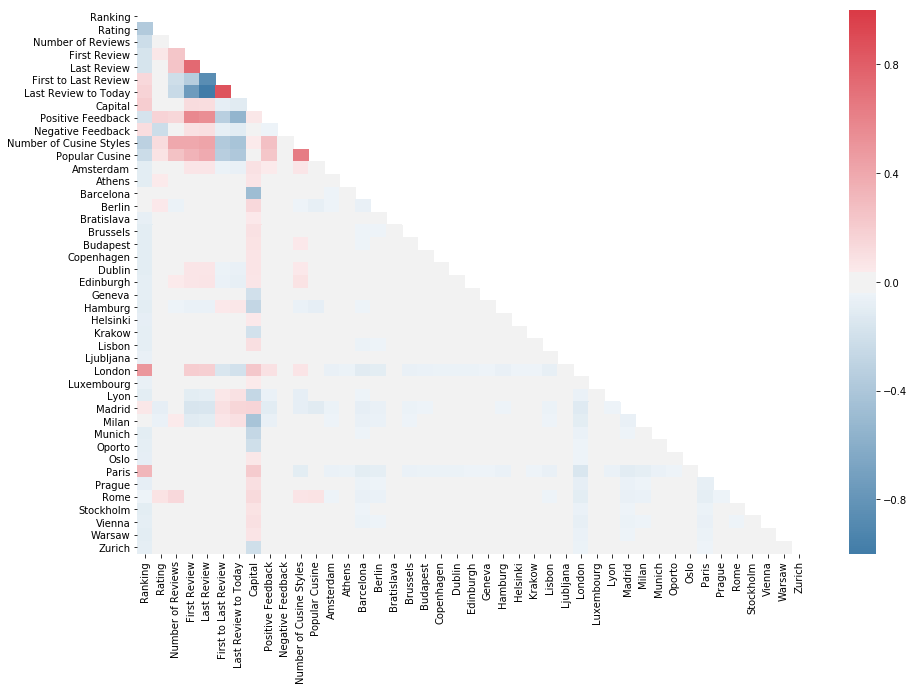

In [14]:
corr = main_data.corr(method='pearson')
plt.figure(figsize=(15,10)) 

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(data=corr, mask=mask, annot=False, cmap=cmap, center=0)


In [15]:
#from sklearn.preprocessing import StandardScaler
#Scaler = StandardScaler()
#Scaler.fit(X_train)
#X_train = pd.DataFrame(Scaler.transform(X_train),columns = X_train.columns)